# Language Translation

* Objective:

Detect Foreign Languages in dataset and perform machine translation backed by Hugging Face models. The quality of machine translation via cloud services has come a very long way and produces high quality results. This notebook shows how the models from Hugging Face give developers a reasonable alternative for local machine translation.

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

%cd '/content/drive/MyDrive'

Mounted at /content/drive
/content/drive/MyDrive


In [2]:
import re
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from pprint import pprint

tqdm.pandas()

In [3]:
dataset = pd.read_excel('./data/merged_clean_data_with_chineese.xlsx')

dataset.isna().sum()

short_description             0
description                   0
caller                        0
group                         0
char_length                   0
word_length                   0
short_char_length             0
short_word_length             0
group_code                    0
char_length_bins              0
cleaned_description          57
cleaned_short_description    50
cleaned_char_length           0
cleaned_word_length           0
cleaned_short_char_length     0
cleaned_short_word_length     0
merged_description            0
dtype: int64

In [4]:
dataset.sample(7)

,short_description,description,caller,group,char_length,word_length,short_char_length,short_word_length,group_code,char_length_bins,cleaned_description,cleaned_short_description,cleaned_char_length,cleaned_word_length,cleaned_short_char_length,cleaned_short_word_length,merged_description
3582,collaboration_platform,\n\nreceived from: xaertwdh.kcsagvpy@gmail.com...,epAYsqnX RAkuDnXG,GRP_0,164,22,22,1,0,18,advise collaboration platform save sync file n...,collaboration platform,72,11,22,2,advise collaboration platform save sync file n...
1435,password is not getting synchronized.,password is not getting synchronized.,bgohnwer ybinfojr,GRP_0,37,5,37,5,0,4,password get synchronize,password get synchronize,24,3,24,3,password get synchronize
2103,hrt archive jobs are failing,hrt archive jobs are failing with error \nora-...,jloygrwh acvztedi,GRP_1,121,19,28,5,1,14,hrt arcve job fail error ora account lock brw...,hrt arcve job fail,81,14,18,4,hrt arcve job fail error ora account lock brw...
7990,as per inc1530161::security incidents - ( in33...,"\nfrom: gzhapcld fdigznbk \nsent: wednesday, a...",gzhapcld fdigznbk,GRP_2,4993,563,115,14,12,87,send wednesday bev loughner gklyop nikszpeu th...,per inc security inent in suspicious ms rpc ms...,3027,428,80,14,send wednesday bev loughner gklyop nikszpeu th...
7599,abended job in job_scheduler: bk_hana_SID_62_e...,received from: monitoring_tool@company.com\n\n...,ZkBogxib QsEJzdZO,GRP_8,121,11,55,5,72,14,abende job job scheduler bk hana sid erp wly dp,abende job job scheduler bk hana sid erp wly dp,48,10,48,10,abende job job scheduler bk hana sid erp wly dp
474,HostName_1030 is currently experiencing high c...,HostName_1030 is currently experiencing high c...,bozdftwx smylqejw,GRP_12,81,9,81,9,4,10,hostname currently experience gh cpu utilizat...,hostname currently experience gh cpu utilizat...,61,7,61,7,hostname currently experience gh cpu utilizat...
282,转发: company email to private phone-hprdlbxf n...,\n\nreceived from: hprdlbxf.nozjtgwi@gmail.com...,hprdlbxf nozjtgwi,GRP_0,127,19,53,7,0,15,help set email access private cell phone,company email private phone,40,7,27,4,company help set email access private cell phone


<h3><ul>
    <li><strong><span style="font-family: 'Trebuchet MS', Helvetica, sans-serif;">Detect Languages in Merged Descriptions using <a href="https://fasttext.cc/docs/en/language-identification.html">fastText language identification model</a>
</ul></h3>

In [5]:
# download pre-trained language detection model

# linux
!wget -O models/lid.176.bin https://dl.fbaipublicfiles.com/fasttext/supervised-models/lid.176.bin

# windows
# !curl -o models/lid.176.bin https://dl.fbaipublicfiles.com/fasttext/supervised-models/lid.176.bin

--2021-10-02 08:48:33--  https://dl.fbaipublicfiles.com/fasttext/supervised-models/lid.176.bin
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 104.22.75.142, 172.67.9.4, 104.22.74.142, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|104.22.75.142|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 131266198 (125M) [application/octet-stream]
Saving to: ‘models/lid.176.bin’

models/lid.176.bin  100%[===================>] 125.18M  24.3MB/s    in 5.7s    

2021-10-02 08:48:40 (21.8 MB/s) - ‘models/lid.176.bin’ saved [131266198/131266198]



In [6]:
# !pip -q install fasttext
import fasttext

# monkey-patch to suppress 'load_model warning from fasttext'
fasttext.FastText.eprint = lambda x: None

     |████████████████████████████████| 68 kB 3.1 MB/s 


In [7]:
# fastText pre-trained language identification model
# (less latency & more accurate)


# lid (Language identification modeel which can recognize 176 languages)
path_to_pretrained_model = './models/lid.176.bin'
lang_model = fasttext.load_model(path_to_pretrained_model)
test = ["+86 Hi there", "c'est", "bitte", "+81"]
pred = lang_model.predict(test)
pprint(test)
pprint([i[0] for i in pred[0]], compact=True)
pprint([i[0] for i in pred[1]], compact=True)

['+86 Hi there', "c'est", 'bitte', '+81']
['__label__en', '__label__fr', '__label__de', '__label__zh']
[0.72783333, 1.0000362, 0.9995301, 0.18863995]


In [8]:
descriptions = dataset.merged_description.tolist()
len(descriptions)

8499

In [9]:
pred_descriptions = lang_model.predict(descriptions)
lang_descriptions = [re.sub("__label__", "", i[0]) for i in pred_descriptions[0]]
lang_descriptions_conf = [i[0] for i in pred_descriptions[1]]

In [10]:
# detected languages with various confidences
pprint({i[0] for i in pred_descriptions[0]}, compact=True)

{'__label__bs', '__label__ca', '__label__cs', '__label__da', '__label__de',
 '__label__en', '__label__eo', '__label__es', '__label__eu', '__label__fa',
 '__label__fi', '__label__fr', '__label__hi', '__label__hr', '__label__hu',
 '__label__id', '__label__it', '__label__ja', '__label__jv', '__label__kn',
 '__label__mk', '__label__ml', '__label__nl', '__label__no', '__label__pl',
 '__label__pt', '__label__ro', '__label__ru', '__label__sh', '__label__sl',
 '__label__sv', '__label__th', '__label__tl', '__label__tr', '__label__ur',
 '__label__zh'}


In [11]:
dataset['language'] = lang_descriptions
dataset['language_confidence'] = lang_descriptions_conf

# language predictions and associated confidence of prediction
dataset.sample(7)[['merged_description', 'language', 'language_confidence']]

,merged_description,language,language_confidence
1333,backup statistic session queue time hour com...,en,0.530055
3594,exepnse info type user new unable create expen...,en,0.785046
7325,unable login microsoft email account,en,0.375863
5649,consultant ycimqn wtubpdsz require collaborati...,en,0.742173
4550,unable print cl,en,0.531243
383,credit memo request approva message process d...,en,0.733216
2827,job job fail job scheduler,en,0.893109


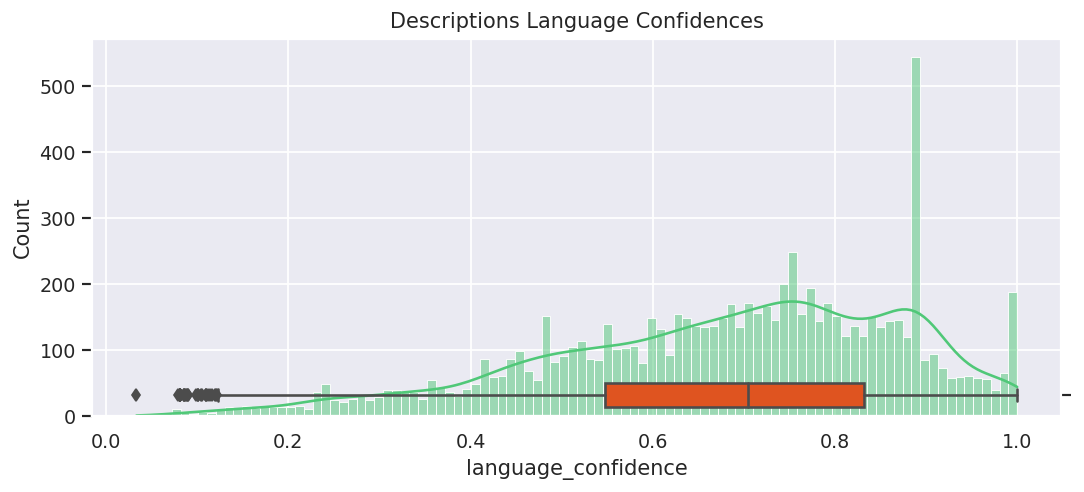

In [12]:
sns.set()
plt.figure(figsize=(10, 4), dpi=125)
ax = sns.histplot(x=dataset.language_confidence, bins=100, kde=True, color='#50C878')
ax_ = ax.twinx()
sns.boxplot(x=dataset.language_confidence, color='#FF4500')
ax_.set(ylim=(-.7, 12))
plt.title('Descriptions Language Confidences')
plt.show()

In [13]:
# check some predictions with less confidence
dataset[(dataset.language != 'en') & (dataset.language_confidence < 0.6)][['merged_description', 'language', 'language_confidence']]

,merged_description,language,language_confidence
2,ca nt log vpn,da,0.132258
4,skype error,ja,0.081046
12,unable login hr tool sgxqsuojr xwbesorf card,zh,0.104415
14,unable open payslip,fr,0.264625
20,unable check payslip,fr,0.172341
...,...,...,...
8396,security error reisekosten abrechnung programdnty,de,0.254021
8413,langsamer rechner uberprufung niptbwdq,de,0.437996
8416,bluetooth keybankrd defekt dardabthyr,sv,0.245299
8426,new able login system user vvrtgwildj name joh...,de,0.548117


In [14]:
# check some predictions with less confidence
dataset[(dataset.language != 'en') & (dataset.language_confidence > 0.6)][['merged_description', 'language', 'language_confidence']]

,merged_description,language,language_confidence
223,probleme bluescreen hallo es ist erneut passie...,de,0.997537
251,reset password bitte passwort fr mail zurckset...,de,0.870327
255,probleme mit laufwerk laeusvjo,de,0.992616
265,hallo netweaver funktioniert nicht mehr bzw ka...,de,0.999658
270,neues passwort fur accountname tgryhu hgygrtui...,de,0.992012
...,...,...,...
8424,kann setzten ich wei mein erp passwort nicht m...,de,0.998999
8438,fur die up lapel druckt nicht richtig der druc...,de,0.999573
8466,send friday nwfodmhc exurcwkm subject wg die...,de,0.969530
8470,"电脑开机开不出来 to 小贺,早上电脑开机开不出来",zh,0.924405


* We can clearly see that low confidence predictions are not right actually foreign-language but interpreted as such because of out of dictionary words and caller names present in the text. So, we overwrite predictions with confidence less than 0.6 back to english

In [15]:
dataset.loc[(dataset.language != 'en') & (dataset.language_confidence < 0.6), 'language'] = 'en'

In [16]:
dataset[(dataset.language != 'en') & (dataset.language_confidence < 0.6)]  # overwritten

,short_description,description,caller,group,char_length,word_length,short_char_length,short_word_length,group_code,char_length_bins,cleaned_description,cleaned_short_description,cleaned_char_length,cleaned_word_length,cleaned_short_char_length,cleaned_short_word_length,merged_description,language,language_confidence


In [17]:
dataset.language.value_counts()

en    7962
de     484
zh      32
pt       8
fr       3
es       2
tl       2
fi       2
ca       2
pl       1
it       1
Name: language, dtype: int64

<h3><ul>
    <li><strong><span style="font-family: 'Trebuchet MS', Helvetica, sans-serif;">Translation using txtai pipelines which use <a href="https://huggingface.co/models?search=Helsinki-NLP%2Fopus-mt">hugging-face language translation models</a> as backend</span></strong>
</ul></h3>

In [18]:
# Install `txtai` and all dependencies. Since this notebook is using optional pipelines
# we need to install the pipeline extras package.

# !pip -q install git+https://github.com/neuml/txtai#egg=txtai[pipeline]

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 8.4 MB 5.1 MB/s 
     |████████████████████████████████| 2.9 MB 56.6 MB/s 
     |████████████████████████████████| 4.8 MB 42.9 MB/s 
     |████████████████████████████████| 1.5 MB 52.2 MB/s 
     |████████████████████████████████| 12.3 MB 42.6 MB/s 
     |████████████████████████████████| 1.2 MB 53.2 MB/s 
     |████████████████████████████████| 3.3 MB 40.7 MB/s 
     |████████████████████████████████| 52 kB 1.2 MB/s 
     |████████████████████████████████| 895 kB 58.6 MB/s 
     |████████████████████████████████| 636 kB 67.9 MB/s 


In [19]:
# The pipeline has logic to detect the input language,
# load the relevant model that handles translating from source to # target language and return results.
# The translation pipeline also has built-in logic to handle splitting large text
# blocks into smaller sections the models can handle.


from txtai.pipeline import Translation

# Create translation model
translate = Translation()

In [20]:
# The translation quality overall is very high
# Machine translation has made giant leaps and strides the last couple of years
# These models are a solid alternative to cloud translation services if translating on local servers is preferred.

translation = translate("Bonjour, Ca va?", "en")

Downloading:   0%|          | 0.00/916k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.26k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/287M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/784k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/760k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.28M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/42.0 [00:00<?, ?B/s]

In [21]:
translation

'Hello, are you okay?'

In [22]:
def translate_foreign_langauges(row):
    original_descr = row.merged_description
    translated_descr = original_descr
    if row.language != 'en':
        if len(original_descr) > 512:
            # pre-trained models only support sequences of length < 512
            orinal_descr = original_descr[:512]
        translation = translate(original_descr, "en")
        if len(translation) > 0:
            translated_descr = translation

    row['translated_description'] = str(translated_descr.strip())
    return row

In [23]:
translated_dataset = dataset.progress_apply(translate_foreign_langauges, axis=1)

  1%|▏         | 107/8499 [00:00<00:07, 1061.97it/s]

Downloading:   0%|          | 0.00/1.11k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/284M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/778k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/750k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.21M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/42.0 [00:00<?, ?B/s]

 12%|█▏        | 1061/8499 [01:31<38:19,  3.23it/s]

Downloading:   0%|          | 0.00/1.12k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/298M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/786k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/788k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.54M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/44.0 [00:00<?, ?B/s]

 14%|█▍        | 1180/8499 [02:12<1:23:43,  1.46it/s]

Downloading:   0%|          | 0.00/1.11k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/328M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/795k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/771k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.26M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/42.0 [00:00<?, ?B/s]

 19%|█▉        | 1610/8499 [02:58<11:20, 10.13it/s]

Downloading:   0%|          | 0.00/1.11k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/279M [00:00<?, ?B/s]

 19%|█▉        | 1618/8499 [03:10<11:19, 10.13it/s]

Downloading:   0%|          | 0.00/796k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/784k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.20M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/42.0 [00:00<?, ?B/s]

 20%|██        | 1713/8499 [03:42<25:01,  4.52it/s]

Downloading:   0%|          | 0.00/1.12k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/287M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/812k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/771k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.31M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/44.0 [00:00<?, ?B/s]

 37%|███▋      | 3138/8499 [05:59<07:28, 11.95it/s]

Downloading:   0%|          | 0.00/1.12k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/296M [00:00<?, ?B/s]

 37%|███▋      | 3162/8499 [06:10<07:26, 11.95it/s]

Downloading:   0%|          | 0.00/690k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/773k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/44.0 [00:00<?, ?B/s]

 40%|███▉      | 3378/8499 [06:31<04:10, 20.40it/s]

Downloading:   0%|          | 0.00/1.16k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/298M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/807k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/783k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.52M [00:00<?, ?B/s]

 40%|███▉      | 3382/8499 [06:45<04:10, 20.40it/s]

Downloading:   0%|          | 0.00/44.0 [00:00<?, ?B/s]

 48%|████▊     | 4041/8499 [08:00<08:56,  8.32it/s]

Downloading:   0%|          | 0.00/1.11k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/295M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/815k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/767k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.45M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/42.0 [00:00<?, ?B/s]

 73%|███████▎  | 6181/8499 [12:51<01:34, 24.62it/s]

Downloading:   0%|          | 0.00/1.12k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/282M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/814k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/806k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.26M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/44.0 [00:00<?, ?B/s]

 82%|████████▏ | 6948/8499 [15:00<00:42, 36.59it/s]

Downloading:   0%|          | 0.00/1.11k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/286M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/800k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/787k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.29M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/42.0 [00:00<?, ?B/s]

 89%|████████▉ | 7575/8499 [16:23<03:01,  5.08it/s]

Downloading:   0%|          | 0.00/1.11k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/289M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/764k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/783k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.43M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/42.0 [00:00<?, ?B/s]

100%|██████████| 8499/8499 [18:34<00:00,  7.62it/s]


In [24]:
# sample translations
translated_dataset[translated_dataset.language == 'de'].sample(20)[['merged_description', 'translated_description']]

,merged_description,translated_description
4397,block necessary unlock user ghjvreicj immediat...,block necessary unlock user ghjvreicj indirect...
1175,hallo zusammen bitte das iphone freischalten...,hello together please unlock the iphone for ma...
463,telefon gigaset m ex professional tel lad nich...,phone gigaset m ex professional tel lad no lon...
223,probleme bluescreen hallo es ist erneut passie...,problems bluescreen hello it has happened agai...
2959,ordnerfreigabe fur kvp und ce leiter,folder sharing for kvp and ce ladder
4694,guten morgen bitte die schreib leseberechtigun...,good morning please set up the write read perm...
6339,probleme mit erpgui vsdtxwry,problems with erpgui vsdtxwry
3445,anmeldung bei account helftgyldt nicht moglich...,registration with account helpgyldt not possib...
1283,keine datenubertragung erp datenbank tintenstr...,no data transfer erp database inkjet printer i...
2927,probleme mit ie niptbwdq,problems with ie niptbwdq


In [25]:
# sample translations
translated_dataset[translated_dataset.language == 'zh'].sample(20)[['merged_description', 'translated_description']]

,merged_description,translated_description
1953,笔记本重新装下系统 把我的笔记本重新装下系统,"The notebooks reset the system, and my noteboo..."
6534,"网络不通 网络不通,右下角网络图标显示未连接到网络。",The network does not work. The network icon at...
1711,"开机黑屏 电脑启动后黑屏,主机无报警",Turn on the black screen. When the computer's ...
7316,"电脑故障 质控部拉力试验机控制电脑的操作系统启动非常缓慢,控制软件丢失。",Computer failure. Quality Control's pull-contr...
1701,"输入用户名和密码后显示出错 登录时输入用户名和密码后,显示用户名和密码错误",Error after entering username and password Aft...
5310,"系统故障,启动蓝屏. 系统故障,启动蓝屏.","System failure, blue screen activated, blue sc..."
3136,"邮箱无法启动 邮箱无法启动,提示无法创新新的堆栈防护页面。",Mailbox could not be started. Mailbox could no...
3314,电脑系统启动蓝屏。 电脑系统启动蓝屏。水不小心洒到电脑里面。,Computer systems start blue screens. Computer ...
1700,"账户被锁定 用户忘记密码,导致账户锁定",The account was locked. The user forgot the pa...
5760,"主机不能开启 主机不能开启,电源灯正常,主机面板1、3指示灯常亮",Hosts can't turn on. Hosts can't turn on. Powe...


In [26]:
translated_dataset.to_excel('./data/clean_data_tranlsated.xlsx')